## **Import Packages**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
!pip install torchsummary
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
from torchvision.transforms import RandomApply, RandomHorizontalFlip
import torchvision.models as models
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
!pip install git+https://github.com/lartpang/PySODMetrics.git
from py_sod_metrics import Fmeasure
!pip install git+https://github.com/Po-Hsun-Su/pytorch-ssim.git
import pytorch_ssim
import shutil
import cv2

2024-05-25 02:30:32.004534: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 02:30:32.004628: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 02:30:32.121548: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


  Cloning https://github.com/lartpang/PySODMetrics.git to /tmp/pip-req-build-uz9343qz
  Running command git clone --filter=blob:none --quiet https://github.com/lartpang/PySODMetrics.git /tmp/pip-req-build-uz9343qz
  Resolved https://github.com/lartpang/PySODMetrics.git to commit 4b1091a474133a4dfd3b1220b63a6669c8b1e774
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for pysodmetrics: filename=pysodmetrics-1.4.2-py3-none-any.whl size=16108 sha256=043d2bdc2ed53f7a55e0a66167ade06370c5cbf07742a1316a6655abd91f0ef0
  Stored in directory: /tmp/pip-ephem-wheel-cache-zzx3f5x6/wheels/05/9f/5b/1f408258fcd0b5808871e08e28be7e42641780675d753c1932
Successfully built pysodmetrics
  Cloning https://github.com/Po-Hsun-Su/pytorch-ssim.git to /tmp/pip-req-build-2dx45rqt
  Running command git clone --filter=blob:none --quiet https://github.com/Po-Hsun-Su/pytorch-ssim.git /tmp/pip-r

## **Dataset, DataLoader, and Transforms**

In [2]:
class GeneralDataset(Dataset): # 用於 training set 和 validation set 的 Dataset
    def __init__(self, path_list, img_size, mode='train'):
      assert mode in ['train', 'val'] # mode 必須是' train' 或 'val'
      self.img_size = img_size
      self.mode = mode
      self.images = []
      self.labels = []
      self.filter_files(path_list)

      self.da_transform = transforms.Compose([
            RandomApply([RandomHorizontalFlip()], p=0.5)
      ])

      # image 預處理操作: 調整大小、轉換為 Tensor、標準化
      self.img_transform = transforms.Compose([
          transforms.Resize((self.img_size, self.img_size)),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

      # ground truth 預處理操作: 調整大小並轉換為 Tensor
      self.label_transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor()])

    def __getitem__(self, index):
      image = Image.open(self.images[index]).convert('RGB')# 打開圖像文件，轉換為RGB
      label = Image.open(self.labels[index]).convert('L')# 打開圖像文件，轉換為灰階影像

      # 若為訓練模式，進行資料擴增
      if self.mode == "train":
        seed = torch.random.initial_seed()
        torch.manual_seed(seed)
        image = self.da_transform(image)
        torch.manual_seed(seed)
        label = self.da_transform(label)
      image = self.img_transform(image)
      label = self.label_transform(label)
      return image, label

    def filter_files(self , path):
      images, labels = [], []
      for path_pair in path :
          img = Image.open(path_pair[0])
          label = Image.open(path_pair[1])
          if img.size == label.size:
              images.append(path_pair[0])
              labels.append(path_pair[1])
      self.images, self.labels = images, labels

    def __len__(self):
        return len(self.images)

In [3]:
class TestlDataset(Dataset):# 用於 testing set 的 Dataset
    def __init__(self, image_root, img_size):
      self.images = sorted([os.path.join(image_root, f) for f in os.listdir(image_root) if f.endswith('.jpg')])
      self.img_size = img_size
      self.img_transform = transforms.Compose([
        transforms.Resize((self.img_size, self.img_size)),
        transforms.ToTensor()])
    def __getitem__(self, index):
      image = Image.open(self.images[index]).convert('RGB')# 打開圖像文件，轉換為 RGB
      image = self.img_transform(image)
      name = os.path.basename(self.images[index]).replace('.jpg', '.png')# 獲取圖像的文件名，並替換後綴
      return image, name
    def __len__(self):
      return len(self.images)

# **data aplit**

In [4]:
# 指定 training set 和 validation set 的路徑
tr_image_root = "/kaggle/input/aicup-data/train/train/Training_dataset/img"
tr_label_root = "/kaggle/input/aicup-data/train/train/Training_dataset/label_img"

train_image_list = sorted([os.path.join(tr_image_root, f) for f in os.listdir(tr_image_root) if f.endswith('.jpg')])
train_label_list = sorted([os.path.join(tr_label_root, f) for f in os.listdir(tr_label_root) if f.endswith('.png')])

# # 因需切割 train data 為 train 與 validation，所以需先讀入data並切割
# # 讀資料
# import glob
# # 找出 train_path 底下所有檔案
# train_image_list = glob.glob(os.path.join(tr_image_root , '*.*') , recursive = True)
# train_label_list = glob.glob(os.path.join(tr_label_root , '*.*') , recursive = True)
l = list(zip(train_image_list , train_label_list))

# 切割
from sklearn.model_selection import train_test_split
train_path_list , val_path_list = train_test_split(l , test_size = 0.2 , random_state = 42)

# **Dataloader**

In [5]:
# 使用 DataLoader 來包裝 training set 和 validation set
# - mode: 設置數據集的模式，設定為 "train "則會做資料擴增
tr_datastet = GeneralDataset(train_path_list,img_size=224, mode="train")
val_datastet = GeneralDataset(val_path_list,img_size=224, mode="val")

# 建立DataLoader來加載 training set 和 validation set
tr_loader = DataLoader(dataset = tr_datastet, batch_size=4, shuffle=True,
                  num_workers=2, pin_memory=True)
val_loader = DataLoader(dataset = val_datastet, batch_size=4, shuffle=True,
                  num_workers=2, pin_memory=True)

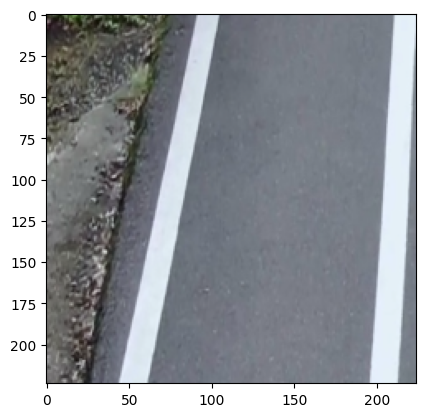

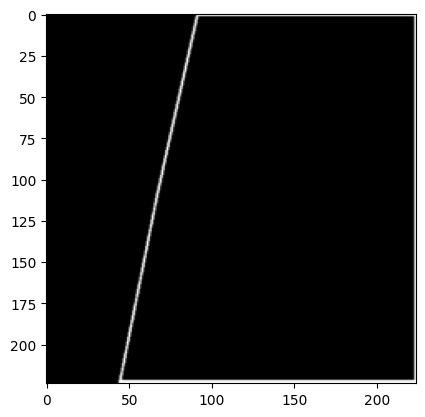

In [6]:
# 檢查 DataLoader 是否成功載入 image 和 ground truth
data_iter = iter(tr_loader)
images, labels = next(data_iter)

image, label = images[0], labels[0]


image = image.numpy()
label = label.numpy()
image = np.transpose(image, (1, 2, 0))
label = np.transpose(label, (1, 2, 0))

if image.min() < 0 or image.max() > 1:
    image = (image - image.min()) / (image.max() - image.min())
plt.imshow(image)
plt.show()
plt.imshow(label, cmap='gray')
plt.show()

## **Model**

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models

class DecoderBlock(nn.Module):
    def __init__(self, in_channel, mid_channel, out_channel, kernel_size, dilation, padding, upsample):
        super(DecoderBlock, self).__init__()

        modules = [
            nn.Conv2d(in_channel, mid_channel, kernel_size=kernel_size, dilation=dilation, padding=padding),
            nn.BatchNorm2d(mid_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channel, mid_channel, kernel_size=kernel_size, dilation=dilation, padding=padding),
            nn.BatchNorm2d(mid_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channel, out_channel, kernel_size=kernel_size, dilation=dilation, padding=padding),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        ]
        #如果upsample=True，則會做upsmapling
        if upsample:
            modules.append(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False))

        self.block = nn.Sequential(*modules)

    def forward(self, x):
        return self.block(x)

class SimpleModel(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(SimpleModel, self).__init__()

        # 載入resnet34作為pre-trainded model
#         resnet = models.vgg19(pretrained=True)
#         resnet = models.resnet18(pretrained=True)
#         resnet = models.resnet34(pretrained=True)
        resnet = models.resnet50(pretrained=True)
#         resnet = models.resnet101(pretrained=True)

        ## -------------Encoder--------------
        self.inconv = nn.Conv2d(n_channels, 64, 3, padding=1)
        self.inbn = nn.BatchNorm2d(64)
        self.inrelu = nn.ReLU(inplace=True)

        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4
        
        
        
#         # vgg19
#         ##-------------Bridge--------------
#         self.bridge = DecoderBlock(512, 512, 512, 3, dilation=2, padding=2, upsample=False)

#         ## -------------Decoder--------------
#         self.decoder4 = DecoderBlock(1024, 512, 512, 3, dilation=1, padding=1, upsample=True)
#         self.decoder3 = DecoderBlock(1024, 512, 256, 3, dilation=1, padding=1, upsample=True)
#         self.decoder2 = DecoderBlock(512, 256, 128, 3, dilation=1, padding=1, upsample=True)
#         self.decoder1 = DecoderBlock(256, 128, 64, 3, dilation=1, padding=1, upsample=False)


        
#         # resnet34
#         ##-------------Bridge--------------
#         self.bridge = DecoderBlock(512, 512, 512, 3, dilation=2, padding=2, upsample=False)

#         ## -------------Decoder--------------
#         self.decoder4 = DecoderBlock(1024, 512, 256, 3, dilation=1, padding=1, upsample=True)
#         self.decoder3 = DecoderBlock(512, 256, 128, 3, dilation=1, padding=1, upsample=True)
#         self.decoder2 = DecoderBlock(256, 128, 64, 3, dilation=1, padding=1, upsample=True)
#         self.decoder1 = DecoderBlock(128, 64, 64, 3, dilation=1, padding=1, upsample=False)



        # resnet50
        ## -------------Bridge--------------
        self.bridge = DecoderBlock(2048, 2048, 2048, 3, dilation=2, padding=2, upsample=False)

        ## -------------Decoder--------------
        self.decoder4 = DecoderBlock(4096, 2048, 1024, 3, dilation=1, padding=1, upsample=True)
        self.decoder3 = DecoderBlock(2048, 1024, 512, 3, dilation=1, padding=1, upsample=True)
        self.decoder2 = DecoderBlock(1024, 512, 256, 3, dilation=1, padding=1, upsample=True)
        self.decoder1 = DecoderBlock(512, 256, 64, 3, dilation=1, padding=1, upsample=False)



#         # resnet101
#         ## -------------Bridge--------------
#         self.bridge = DecoderBlock(2048, 2048, 2048, 3, dilation=2, padding=2, upsample=False)

#         ## -------------Decoder--------------
#         self.decoder4 = DecoderBlock(4096, 2048, 1024, 3, dilation=1, padding=1, upsample=True)
#         self.decoder3 = DecoderBlock(2048, 1024, 512, 3, dilation=1, padding=1, upsample=True)
#         self.decoder2 = DecoderBlock(1024, 512, 256, 3, dilation=1, padding=1, upsample=True)
#         self.decoder1 = DecoderBlock(512, 256, 64, 3, dilation=1, padding=1, upsample=False)



        ## -------------Final Convolution Layer--------------
        self.final_conv = nn.Conv2d(64, n_classes, 3, padding=1)

    def forward(self, x):
        hx = self.inrelu(self.inbn(self.inconv(x)))

        e1 = self.encoder1(hx)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        b = self.bridge(e4)

        d4 = self.decoder4(torch.cat((e4, b), dim=1))
        d3 = self.decoder3(torch.cat((e3, d4), dim=1))
        d2 = self.decoder2(torch.cat((e2, d3), dim=1))
        d1 = self.decoder1(torch.cat((e1, d2), dim=1))

        out = self.final_conv(d1)

        return torch.sigmoid(out)

In [8]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-vocky7af
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-vocky7af
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 3bf4d6ef2bc9d41c2ab3436838aa22375dd0f23a
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.3 MB/s eta 0:00:00
  Created wheel for segmentation_models_pytorch: filename=segmentation_models_pytorch-0.3.3-py3-none-any.whl size=106718 sha256=aaecc7cdbd7c2ff21963af564d24dc69c2

In [9]:
# DeepLabV3Plus
# model = smp.UnetPlusPlus("resnet50", encoder_weights="imagenet", activation=None)
model = SimpleModel(n_channels=3,n_classes = 1)
model.load_state_dict(torch.load("/kaggle/input/resnet50-models/models/checkpoint_model_15.pth"))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
summary(model, (3, 224, 224))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]           4,096
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]          36,864
       BatchNorm2d-8         [-1, 64, 224, 224]             128
              ReLU-9         [-1, 64, 224, 224]               0
           Conv2d-10        [-1, 256, 224, 224]          16,384
      BatchNorm2d-11        [-1, 256, 224, 224]             512
           Conv2d-12        [-1, 256, 224, 224]          16,384
      BatchNorm2d-13        [-1, 256, 224, 224]             512
             ReLU-14        [-1, 256, 2

# **Define loss function**

In [10]:
class IOU(nn.Module):
    def __init__(self, size_average=True):
        super(IOU, self).__init__()
        self.size_average = size_average

    def forward(self, pred, target):
        b = pred.shape[0]
        IoU = 0.0
        for i in range(b):
            Iand1 = torch.sum(target[i, :, :, :] * pred[i, :, :, :])
            Ior1 = torch.sum(target[i, :, :, :]) + torch.sum(pred[i, :, :, :]) - Iand1
            IoU1 = Iand1 / Ior1
            IoU += (1 - IoU1)
        return IoU / b if self.size_average else IoU


iou_loss_module = IOU(size_average=True)
bce_loss_module = nn.BCEWithLogitsLoss()
ssim_loss_module = pytorch_ssim.SSIM(window_size=11,size_average=True)

# **Training**

In [11]:
#設定權重儲存的路徑
save_path = './models'
os.makedirs(save_path, exist_ok=True)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
epoch_num = 30
optimizer = optim.Adam(model.parameters(), lr=0.001)

# loss為無限大
best_val_loss = float('inf')

# 紀錄loss
train_loss_list = []
val_loss_list = []
fm_score_list = []

for epoch in range(15 , epoch_num):
    ## -------------Training stage--------------
    model.train()
    loss_all = 0
    epoch_step = 0
    for images, labels in tr_loader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss_iou = iou_loss_module(outputs, labels)
        loss_bce = bce_loss_module(outputs, labels)
        ssim_loss = 1 - ssim_loss_module(outputs,labels)
        loss = loss_iou + loss_bce + ssim_loss
        loss.backward()
        optimizer.step()

        epoch_step += 1
        loss_all += loss.item()

    avg_train_loss = loss_all / epoch_step
    train_loss_list.append(avg_train_loss)

    ## -------------Validation stage--------------
    model.eval()
    with torch.no_grad():
        val_loss_all = 0
        val_step = 0
        
        fm_score_all = 0

        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss_iou = iou_loss_module(outputs, labels)
            loss_bce = bce_loss_module(outputs, labels)
            ssim_loss = 1 - ssim_loss_module(outputs,labels)
            val_loss = loss_iou + loss_bce + ssim_loss

            val_loss_all += val_loss.item()
            val_step += 1


        avg_val_loss = val_loss_all / val_step
        val_loss_list.append(avg_val_loss)

    # 儲存最好的權重
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = os.path.join(save_path, f'best_model.pth')
        torch.save(model.state_dict(), best_model_path)
        print('New best model saved at epoch', epoch + 1)
        
    # check point
    if epoch == epoch_num - 1 :
        checkpoint_model_path = os.path.join(save_path, f'checkpoint_model_{epoch + 1}.pth')
        torch.save(model.state_dict(), checkpoint_model_path)
        print('New checkpoint model saved at epoch', epoch + 1)

    print(f"Epoch [{epoch+1}/{epoch_num}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

New best model saved at epoch 16
Epoch [16/30], Train Loss: 1.2865, Val Loss: 1.3009
New best model saved at epoch 17
Epoch [17/30], Train Loss: 1.2863, Val Loss: 1.2932
New best model saved at epoch 18
Epoch [18/30], Train Loss: 1.2816, Val Loss: 1.2851
Epoch [19/30], Train Loss: 1.2765, Val Loss: 1.2889
Epoch [20/30], Train Loss: 1.2789, Val Loss: 1.2862
Epoch [21/30], Train Loss: 1.2738, Val Loss: 1.2861
New best model saved at epoch 22
Epoch [22/30], Train Loss: 1.2712, Val Loss: 1.2821
New best model saved at epoch 23
Epoch [23/30], Train Loss: 1.2670, Val Loss: 1.2770
New best model saved at epoch 24
Epoch [24/30], Train Loss: 1.2651, Val Loss: 1.2735
Epoch [25/30], Train Loss: 1.2697, Val Loss: 1.2814
New best model saved at epoch 26
Epoch [26/30], Train Loss: 1.2660, Val Loss: 1.2709
Epoch [27/30], Train Loss: 1.2626, Val Loss: 1.3493
Epoch [28/30], Train Loss: 1.2657, Val Loss: 1.2724
Epoch [29/30], Train Loss: 1.2570, Val Loss: 1.2715
New checkpoint model saved at epoch 30
Ep

# **Testing**

In [12]:
test_image_root = "/kaggle/input/aicup-data/test/test/img"
ts_dataset = TestlDataset(image_root=test_image_root, img_size=224)
ts_loader = DataLoader(dataset=ts_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)
model = SimpleModel(n_channels=3, n_classes=1)
# model = smp.Unet++("resnet34", encoder_weights="imagenet", activation=None)
model.load_state_dict(torch.load("./models/best_model.pth"))
model.cuda()
model.eval()
save_path = "./result"
os.makedirs(save_path, exist_ok=True)

with torch.no_grad():
    for images, names in ts_loader:
      images = images.cuda()
      results = model(images)
      results = F.interpolate(results, size=(240, 428), mode='bilinear', align_corners=False)
      results = results.data.cpu().numpy()
      for idx, name in enumerate(names):
          res = results[idx].squeeze()
          success = cv2.imwrite(os.path.join(save_path, name), res * 255)
          if success:
              print(f"File saved successfully: {name}")
          else:
              print(f"Failed to save file: {name}")

File saved successfully: PUB_RI_2000000.png
File saved successfully: PUB_RI_2000001.png
File saved successfully: PUB_RI_2000002.png
File saved successfully: PUB_RI_2000003.png
File saved successfully: PUB_RI_2000004.png
File saved successfully: PUB_RI_2000005.png
File saved successfully: PUB_RI_2000006.png
File saved successfully: PUB_RI_2000007.png
File saved successfully: PUB_RI_2000008.png
File saved successfully: PUB_RI_2000009.png
File saved successfully: PUB_RI_2000010.png
File saved successfully: PUB_RI_2000011.png
File saved successfully: PUB_RI_2000012.png
File saved successfully: PUB_RI_2000013.png
File saved successfully: PUB_RI_2000014.png
File saved successfully: PUB_RI_2000015.png
File saved successfully: PUB_RI_2000016.png
File saved successfully: PUB_RI_2000017.png
File saved successfully: PUB_RI_2000018.png
File saved successfully: PUB_RI_2000019.png
File saved successfully: PUB_RI_2000020.png
File saved successfully: PUB_RI_2000021.png
File saved successfully: PUB_RI_

# **Submission**

In [13]:
#壓縮檔案成zip檔
directory_to_compress = './result'
shutil.make_archive('submission_file', 'zip', directory_to_compress)

'/kaggle/working/submission_file.zip'